# Case Study: Tobacco Plant Recognition

Please read the following research paper for the problem description and objectives:

**Real-Time Machine-Learning Based Crop/Weed Detection and Classification for Variable-Rate Spraying in Precision Agriculture**  
[https://www.researchgate.net/publication/341719983_Real-Time_Machine-Learning_Based_CropWeed_Detection_and_Classification_for_Variable-Rate_Spraying_in_Precision_Agriculture](https://www.researchgate.net/publication/341719983_Real-Time_Machine-Learning_Based_CropWeed_Detection_and_Classification_for_Variable-Rate_Spraying_in_Precision_Agriculture)

**Author:** Dr. Muhammad Tufail  
**Institution:** Red Deer Polytechnic  
**Course:** Computer Vision — Fall 2025

# What are we detecting/classifying in Images and How?

We have a dataset of tobacco plants available online: https://github.com/mshahabalam/TobSet/:

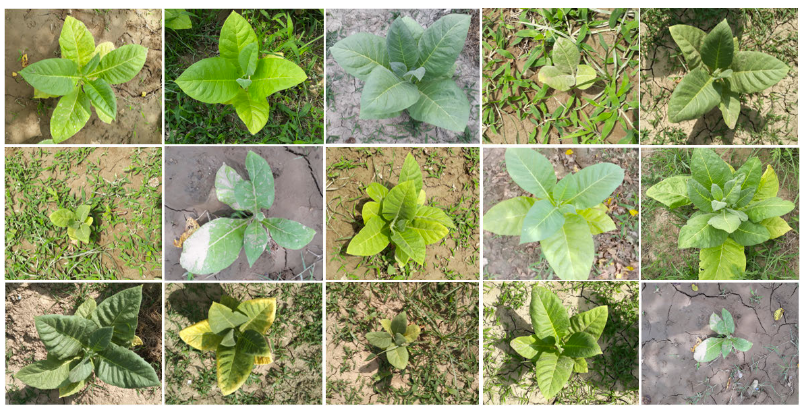




Here is the machine learning pipline we plant to implement in this notebook:

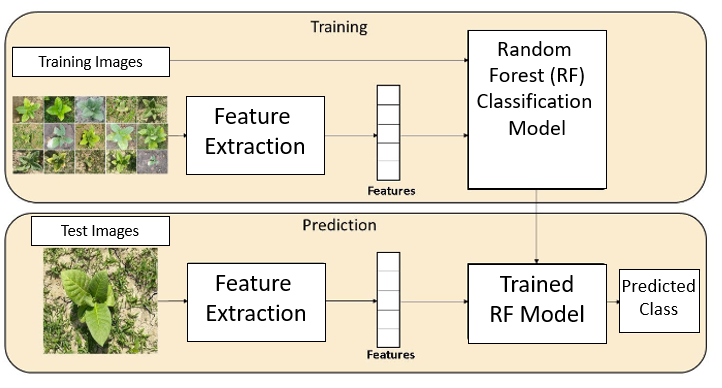


The diagram illustrates the **workflow of the tobacco image classification pipeline**.
During the **training phase**, feature vectors are extracted from multiple labeled training images and used to train a **Random Forest (RF) classification model**.
In the **prediction phase**, the same feature extraction process is applied to new test images, whose resulting feature vectors are fed into the **trained RF model** to produce the final **predicted class label**.




# Key Concpets and Steps to Implement Tobacco Classification  

### Using Hand-Crafted Features and Random Forest

This notebook demonstrates a **classical machine learning pipeline** for plant-image classification in precision agriculture.  
It focuses on distinguishing **tobacco leaves** from **non-tobacco vegetation** such as *grass, mint, sunflower,* and *weeds* using traditional computer-vision features and a Random Forest classifier.

---

## Overview

### 1️⃣ Data Preparation and Augmentation
- Loads images from `./dataset/train/`.
- Resizes all images to **640×480** for consistency.
- Applies multiple augmentations to increase dataset diversity:
  - Horizontal / vertical flips  
  - Random rotations (±15°)  
  - Brightness and contrast variations  
  - Gaussian blur and Gaussian noise
- Saves augmented images in corresponding folders (e.g., `./dataset/train/grass_aug/`).

---

### 2️⃣ Feature Extraction
Each image is represented by a **global feature vector** composed of:
- **Color Histogram (HSV):** captures dominant hues.  
- **Haralick Texture:** quantifies spatial gray-level patterns.  
- **Hu Moments:** invariant shape descriptors.  
- **EOG Histogram:** gray-level intensity distribution.  
- *(Optional)* **Edge Density:** separates thin grass blades from broad tobacco leaves.

All extracted features and labels are stored in:

`./output/data_tobacco_binary.h5`


### 3️⃣ Model Training
- Splits the dataset into **training (80%)** and **validation (20%)** using `train_test_split`.
- Trains a **RandomForestClassifier** with:
  - `n_estimators = 150`  
  - `class_weight = 'balanced'`
- Evaluates performance using accuracy, precision, recall, and F1-score.
- Saves the trained model as:

`output/tobacco_rf_model.pkl`


### 4️⃣ Evaluation on Unseen Data
The trained model is evaluated on a **diverse test set** located in:

dataset/test/
├── tobacco/
├── grass/
├── mint/
├── sunflower/
└── weeds/


The notebook:
- Loads the saved Random Forest model.  
- Predicts each image’s class and computes:
  - Folder-wise accuracy  
  - Global confusion matrix and classification report  
- Optionally saves **misclassified samples** with predicted and true labels for inspection.

---

### 5️⃣ Key Findings
- Achieved **~97% overall accuracy** on the test set.  
- Perfect classification for *mint, sunflower,* and *weeds.*  
- Some **false positives on grass**, due to color-texture similarity with tobacco leaves.  
- Demonstrates strengths and limits of feature-based models in real agricultural imagery.

---

## Learning Objectives
- Practice classical (non-deep-learning) image feature extraction.  
- Train and evaluate a supervised model (Random Forest) for image recognition.  
- Assess model generalization on unseen plant types.  
- Explore feature refinement and threshold tuning to minimize false positives.

---

## Dependencies
Make sure these packages are installed:

- numpy
- opencv-python
- scikit-image
- scikit-learn
- matplotlib
- mahotas
- h5py
- tqdm
- joblib

You can install them by running:

`pip install -r requirements.txt`


In [ ]:
!pip install -r requirements.txt

## Step 1: Data Augumentationn

| Step                | Action                             | Output                |
| ------------------- | ---------------------------------- | --------------------- |
| Resize              | Converts all images to **640×480** | Standardized size     |
| Flip                | Horizontal + vertical flips        | 2× more data          |
| Rotate              | −15° and +15°                      | Slight view variation |
| Brightness/contrast | Simulate lighting changes          | 2× more data          |
| Gaussian blur       | Simulates motion/focus variations  | Adds realism          |
| Gaussian noise      | Simulates camera grain             | Adds realism          |


In [1]:
import cv2
import os
import numpy as np
from tqdm import tqdm

input_dir = "./dataset/grass"
output_dir = "./dataset/train/grass_aug"
os.makedirs(output_dir, exist_ok=True)

# =====================================================
# Helper functions
# =====================================================

def adjust_brightness_contrast(image, brightness=0, contrast=0):
    beta = brightness
    alpha = contrast / 127 + 1.0
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def add_gaussian_noise(image, mean=0, var=20):
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, image.shape).astype('float32')
    noisy = np.clip(image.astype('float32') + gauss, 0, 255).astype('uint8')
    return noisy

def augment_image(image):
    """Apply multiple random augmentations and return a list of variants"""
    augmented = []

    # Horizontal flip
    augmented.append(cv2.flip(image, 1))

    # Vertical flip
    augmented.append(cv2.flip(image, 0))

    # Rotate small angles
    for angle in [-15, 15]:
        (h, w) = image.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h))
        augmented.append(rotated)

    # Brightness and contrast changes
    augmented.append(adjust_brightness_contrast(image, brightness=30, contrast=40))
    augmented.append(adjust_brightness_contrast(image, brightness=-30, contrast=-40))

    # Blur and noise
    augmented.append(cv2.GaussianBlur(image, (5, 5), 0))
    augmented.append(add_gaussian_noise(image))

    return augmented

# =====================================================
# Process images
# =====================================================

print(f"[INFO] Processing images from {input_dir}...")
counter = 0

for file in tqdm(os.listdir(input_dir)):
    if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    img_path = os.path.join(input_dir, file)
    img = cv2.imread(img_path)
    if img is None:
        continue

    # Resize to 640x480 (width x height)
    resized = cv2.resize(img, (640, 480))

    # Save base resized image
    base_name = os.path.splitext(file)[0]
    cv2.imwrite(os.path.join(output_dir, f"{base_name}_resized.jpg"), resized)
    counter += 1

    # Apply augmentations
    for i, aug_img in enumerate(augment_image(resized)):
        out_name = os.path.join(output_dir, f"{base_name}_aug{i+1}.jpg")
        cv2.imwrite(out_name, aug_img)
        counter += 1

print(f"[INFO] Preprocessing complete. Saved {counter} images in {output_dir}")


[INFO] Processing images from ./dataset/grass...


100%|██████████| 61/61 [00:17<00:00,  3.40it/s]

[INFO] Preprocessing complete. Saved 549 images in ./dataset/train/grass_aug


In [ ]:
#!pip install tqdm

In [ ]:
#!pip install --upgrade --force-reinstall h5py


  Using cached h5py-3.14.0-cp313-cp313-win_amd64.whl.metadata (2.7 kB)
  Using cached numpy-2.3.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
Using cached h5py-3.14.0-cp313-cp313-win_amd64.whl (2.9 MB)
Using cached numpy-2.3.3-cp313-cp313-win_amd64.whl (12.8 MB)

  Attempting uninstall: numpy

    Found existing installation: numpy 2.3.1

   ---------------------------------------- 0/2 [numpy]
    Uninstalling numpy-2.3.1:
   ---------------------------------------- 0/2 [numpy]
      Successfully uninstalled numpy-2.3.1
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ------------------------

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyfeats 1.0.1 requires mahotas, which is not installed.


# Step 2: Train a Random Forest Classifier

In [3]:
import os
import cv2
import h5py
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import graycomatrix, graycoprops

# =====================================================
# Feature extraction functions
# =====================================================

def fd_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray,
                        distances=[1],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        symmetric=True,
                        normed=True)
    features = [
        graycoprops(glcm, 'contrast').mean(),
        graycoprops(glcm, 'dissimilarity').mean(),
        graycoprops(glcm, 'homogeneity').mean(),
        graycoprops(glcm, 'ASM').mean(),
        graycoprops(glcm, 'energy').mean(),
        graycoprops(glcm, 'correlation').mean()
    ]
    return np.array(features)

def fd_hu_moments(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray)
    hu = cv2.HuMoments(moments)
    return hu.flatten()

def fd_eoghistogram(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# =====================================================
# Paths and Parameters
# =====================================================

train_path = "dataset/train"
h5_data = "output/data_tobacco_binary.h5"
test_size = 0.2
seed = 42

os.makedirs("output", exist_ok=True)

# =====================================================
# Feature extraction
# =====================================================

global_features = []
labels = []

print("[INFO] Starting feature extraction...")

for label_name in os.listdir(train_path):
    dir_path = os.path.join(train_path, label_name)
    if not os.path.isdir(dir_path):
        continue

    # Assign binary label: 1 for tobacco, 0 for everything else
    label = 1 if label_name.lower() == "tobacco" else 0
    print(f"[INFO] Processing '{label_name}' → Label: {label}")

    for file in tqdm(os.listdir(dir_path)):
        file_path = os.path.join(dir_path, file)
        image = cv2.imread(file_path)
        if image is None:
            continue

        # Extract features
        fv_histogram = fd_histogram(image)
        fv_haralick = fd_haralick(image)
        fv_hu_moments = fd_hu_moments(image)
        fv_eoghistogram = fd_eoghistogram(image)

        global_feature = np.hstack([
            fv_histogram,
            fv_haralick,
            fv_hu_moments,
            fv_eoghistogram
        ])

        global_features.append(global_feature)
        labels.append(label)

print(f"[INFO] Feature extraction complete: {len(global_features)} samples")

# Save features
with h5py.File(h5_data, 'w') as f:
    f.create_dataset('features', data=np.array(global_features))
    f.create_dataset('labels', data=np.array(labels))
print(f"[INFO] Saved: {h5_data}")

# =====================================================
# Train binary classifier
# =====================================================

X = np.array(global_features)
y = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=test_size, random_state=seed, stratify=y
)

clf = RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=seed)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
print("[INFO] Validation accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=["Non-Tobacco", "Tobacco"]))

# =====================================================
# Inference
# =====================================================

def predict_image(img_path, threshold=0.6):
    image = cv2.imread(img_path)
    if image is None:
        return "Invalid image"

    fv_histogram = fd_histogram(image)
    fv_haralick = fd_haralick(image)
    fv_hu_moments = fd_hu_moments(image)
    fv_eoghistogram = fd_eoghistogram(image)

    feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments, fv_eoghistogram]).reshape(1, -1)
    prob = clf.predict_proba(feature)[0][1]  # probability of being 'Tobacco'
    print("Tobacco probability:", prob)


    return "Tobacco" if prob > threshold else "Non-Tobacco"

# Example
# print("[TEST] ", predict_image("dataset/test/sample.jpg"))


[INFO] Starting feature extraction...
[INFO] Processing 'grass_aug' → Label: 0


100%|██████████| 549/549 [00:23<00:00, 23.18it/s]


[INFO] Processing 'tobacco' → Label: 1


100%|██████████| 250/250 [00:11<00:00, 20.91it/s]


[INFO] Feature extraction complete: 799 samples
[INFO] Saved: output/data_tobacco_binary.h5
[INFO] Validation accuracy: 1.0
              precision    recall  f1-score   support

 Non-Tobacco       1.00      1.00      1.00       110
     Tobacco       1.00      1.00      1.00        50

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



### Analyzing the output:

| Class       | Samples | Notes                                      |
| ----------- | ------- | ------------------------------------------ |
| `grass_aug` | 549     | non-tobacco negatives (augmented, diverse) |
| `tobacco`   | 250     | positive images                            |
| **Total**   | **799** | balanced, healthy dataset size             |

The Random Forest classifier has achieved:

Validation accuracy: 1.0

Precision/Recall/F1 for both classes: 1.0

That’s ideal on internal validation, meaning:

- The augmented negatives are sufficiently distinct from tobacco,
- The feature descriptors (color histogram + Haralick + Hu + EOG) are highly discriminative.


### 2.1. Save your trained RF model


In [6]:
import joblib
joblib.dump(clf, "./output/tobacco_rf_model.pkl")


['./output/tobacco_rf_model.pkl']

### 2.2. Relad the model


In [ ]:
clf = joblib.load("output/tobacco_rf_model.pkl")


# Step 3: Model Evaluation

The following cell does:

- It automatically detects all subfolders under dataset/test/.
- Treats anything not named “tobacco” as non-tobacco (label = 0).
- Evaluates and reports results per subfolder so you can see how your classifier behaves for each category (grass vs mint vs sunflower vs weeds).

How it works:

| Step | Action                                                             |
| ---- | ------------------------------------------------------------------ |
| 1️⃣  | Loads your trained `tobacco_rf_model.pkl`                          |
| 2️⃣  | Iterates through *every folder* in `dataset/test/`                 |
| 3️⃣  | Assigns label = 1 for `"tobacco"`; label = 0 for all other folders |
| 4️⃣  | Extracts same feature vectors (color histogram, Haralick, Hu, EOG) |
| 5️⃣  | Predicts and computes per-folder and global accuracy               |
| 6️⃣  | Prints a confusion matrix and classification report                |



In [11]:
import os
import cv2
import joblib
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import graycomatrix, graycoprops

# =====================================================
# Feature extraction functions (same as training)
# =====================================================
def fd_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray,
                        distances=[1],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        symmetric=True,
                        normed=True)
    features = [
        graycoprops(glcm, 'contrast').mean(),
        graycoprops(glcm, 'dissimilarity').mean(),
        graycoprops(glcm, 'homogeneity').mean(),
        graycoprops(glcm, 'ASM').mean(),
        graycoprops(glcm, 'energy').mean(),
        graycoprops(glcm, 'correlation').mean()
    ]
    return np.array(features)

def fd_hu_moments(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray)
    hu = cv2.HuMoments(moments)
    return hu.flatten()

def fd_eoghistogram(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# =====================================================
# Paths
# =====================================================
model_path = "./output/tobacco_rf_model.pkl"
test_path = "./dataset/test"

clf = joblib.load(model_path)
print(f"[INFO] Loaded model from {model_path}")

# =====================================================
# Evaluate all subfolders
# =====================================================
true_labels, pred_labels = [], []
folder_results = {}

print(f"[INFO] Scanning subfolders in {test_path}...\n")

for folder_name in sorted(os.listdir(test_path)):
    folder_path = os.path.join(test_path, folder_name)
    if not os.path.isdir(folder_path):
        continue

    label = 1 if folder_name.lower() == "tobacco" else 0
    folder_true, folder_pred = [], []

    print(f"[INFO] Processing folder: {folder_name} (Label={label})")

    for file in tqdm(os.listdir(folder_path)):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(folder_path, file)
        image = cv2.imread(img_path)
        if image is None:
            continue

        # Extract same features as in training
        fv_histogram = fd_histogram(image)
        fv_haralick = fd_haralick(image)
        fv_hu_moments = fd_hu_moments(image)
        fv_eoghistogram = fd_eoghistogram(image)
        feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments, fv_eoghistogram]).reshape(1, -1)

        pred = clf.predict(feature)[0]
        folder_true.append(label)
        folder_pred.append(pred)

    # Record per-folder results
    if len(folder_true) > 0:
        cm = confusion_matrix(folder_true, folder_pred, labels=[0, 1])
        acc = np.trace(cm) / np.sum(cm)
        folder_results[folder_name] = acc
        print(f"    → Accuracy for '{folder_name}': {acc:.2f}")

    true_labels.extend(folder_true)
    pred_labels.extend(folder_pred)

# =====================================================
# Global report
# =====================================================
print("\n=================== GLOBAL REPORT ===================")
print(classification_report(true_labels, pred_labels, target_names=["Non-Tobacco", "Tobacco"]))

cm_global = confusion_matrix(true_labels, pred_labels, labels=[0, 1])
print("Confusion Matrix:\n", cm_global)

print("\nPer-Class Accuracy:")
for name, acc in folder_results.items():
    print(f"  {name:10s} : {acc:.2f}")


[INFO] Loaded model from ./output/tobacco_rf_model.pkl
[INFO] Scanning subfolders in ./dataset/test...

[INFO] Processing folder: grass (Label=0)


100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


    → Accuracy for 'grass': 0.43
[INFO] Processing folder: mint (Label=0)


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


    → Accuracy for 'mint': 1.00
[INFO] Processing folder: sunflower (Label=0)


100%|██████████| 2/2 [00:00<00:00,  3.91it/s]


    → Accuracy for 'sunflower': 1.00
[INFO] Processing folder: tobacco (Label=1)


100%|██████████| 250/250 [00:14<00:00, 17.70it/s]


    → Accuracy for 'tobacco': 0.98
[INFO] Processing folder: weeds (Label=0)


100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

    → Accuracy for 'weeds': 1.00

=================== GLOBAL REPORT ===================
              precision    recall  f1-score   support

 Non-Tobacco       0.76      0.76      0.76        17
     Tobacco       0.98      0.98      0.98       250

    accuracy                           0.97       267
   macro avg       0.87      0.87      0.87       267
weighted avg       0.97      0.97      0.97       267

Confusion Matrix:
 [[ 13   4]
 [  4 246]]

Per-Class Accuracy:
  grass      : 0.43
  mint       : 1.00
  sunflower  : 1.00
  tobacco    : 0.98
  weeds      : 1.00


### 3.1. Let's analyze the evaluation results

| Folder        | Label       | Accuracy | Notes                                    |
| ------------- | ----------- | -------- | ---------------------------------------- |
| **grass**     | Non-tobacco | ⚠️ 0.43  | The only class still confusing the model |
| **mint**      | Non-tobacco | ✅ 1.00   | Perfect — looks structurally different   |
| **sunflower** | Non-tobacco | ✅ 1.00   | Distinct color and shape                 |
| **weeds**     | Non-tobacco | ✅ 1.00   | Well separated                           |
| **tobacco**   | Tobacco     | ✅ 0.98   | Excellent internal consistency           |


Overall accuracy: 0.97

F1-score (macro): 0.87

So, your RandomForest correctly identifies most tobacco and non-tobacco classes but still mistakes 4 grass images as tobacco.

🔍 Why “grass” is the hardest

Grass and young tobacco plants share:

- Similar green color histograms in HSV space,

- Comparable leaf textures under similar lighting,

- Overlapping Haralick and EOG features (since both have high local contrast and repetitive textures).

Your current model is feature-driven (hand-crafted color and texture descriptors), so when the background or lighting matches, it leans toward the dominant class (tobacco).

# Step 4 (OPTIONAL): Suggested Extensions
- Collect additional grass images under varied lighting and angles.  
- Tune the prediction threshold (`prob > 0.7`) to reduce false positives.  
- Add shape-based descriptors (e.g., edge density).  
- Compare Random Forest performance with a lightweight CNN (MobileNetV2 or EfficientNet-B0).

